### Installing the dependencies

In [8]:
# !pip install torch numpy pandas seaborn plotly wordcloud nbformat --upgrade spacy scikit-learn transformers

### Step 1 : Importing the libraries

In [42]:
import torch
import numpy as np
import pandas as pd
from rich import print
import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import spacy
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm") 
import re
import contractions
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader

print("Everything imported succesfully")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 8.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


Everything imported succesfully

| **Requirement Type**         | **Count** | **Details**                                                                 |
|-------------------------------|-----------|-----------------------------------------------------------------------------|
| **Functional Requirement (F)**| 444       | Requirements specifying what the system must do.                           |
| **Non-Functional Requirements (NFRs)** | 525       | Attributes related to how the system performs rather than what it does.    |
| &nbsp;&nbsp;Availability (A)         | 31        | Uptime and fault tolerance capabilities.                                   |
| &nbsp;&nbsp;Legal (L)                | 15        | Compliance with legal and regulatory standards.                           |
| &nbsp;&nbsp;Look-and-Feel (LF)       | 49        | Aesthetic and design-related requirements.                                |
| &nbsp;&nbsp;Maintainability (MN)     | 24        | Ease of updating and maintaining the system.                              |
| &nbsp;&nbsp;Operability (O)          | 77        | Ease of operations and management by users or administrators.             |
| &nbsp;&nbsp;Performance (PE)         | 67        | Response time, throughput, and efficiency metrics.                        |
| &nbsp;&nbsp;Scalability (SC)         | 22        | Ability to scale with increased workload.                                 |
| &nbsp;&nbsp;Security (SE)            | 125       | Protection against unauthorized access, threats, and vulnerabilities.     |
| &nbsp;&nbsp;Usability (US)           | 85        | Ease of use and user experience.                                          |
| &nbsp;&nbsp;Fault Tolerance (FT)     | 18        | System’s ability to recover from faults or errors.                        |
| &nbsp;&nbsp;Portability (PO)         | 12        | Ability to transfer the system to different environments/platforms.       |

### Dataset Preperation for first step of classification
- For the very first stage we will do functional vs non functional classification so we will simply create dataset for that first

In [31]:
# Reading the csv file
df = pd.read_csv("data/PROMISE_exp.csv")

# Removing the ProjectID as it is of no use for classification
df.drop(['ProjectID'],axis=1,inplace=True)

print(df.shape)

(969, 2)

In [32]:
# Checking 5 random rows of the data
df.sample(5)

,RequirementText,_class_
904,The system shall send an order confirmation to...,F
378,System shall let administrator de-activate a c...,PE
713,Enable the admin to generate reports which con...,F
312,The product shall be able to be installed in a...,O
711,Enable a logged in user to up vote and down vo...,F


Now since we need to create dataseets for 2 different kinds of classificaton thus we need to make sure we are first creating the copy of the raw original dataset and fro that we will fetch 2 required datasets

In [33]:
# Storying the copy of the original dataframe
df1 = df.copy()
df2 = df.copy()

In [34]:
def segregate_data(df1, df2):
    """
    Segregates the data into two datasets for different levels of classification.
    
    This function takes two dataframes as input, df1 and df2, which are copies of the original dataset.
    It modifies df1 by replacing all non-functional categories with 'NF' label and saves it as DataV1.csv.
    It modifies df2 by removing all rows with 'F' label and saves it as DataV2.csv.
    
    Parameters:
    df1 (DataFrame): The first dataframe to be modified and saved.
    df2 (DataFrame): The second dataframe to be modified and saved.
    """
    # Going over the rows and replacing all the Non functional categories with NFR label
    for i in range(len(df1)):
        label = df1.at[i,'_class_']
        if label != 'F':
            df1.at[i,'_class_'] = 'NF'

    # Saving this data for very first layer of classification
    df1.to_csv("data/DataV1.csv",index=False)

    # Removing the functional requirments lable from the data df2
    df2 = df2[df2['_class_'] != 'F']
    df2.to_csv("data/DataV2.csv",index=False)

# Calling the function
segregate_data(df1,df2)


# Stage 1 : Classification (Functional requirements / Non functional requirements)

adfhskfjksdfjk s jsd jsdjfksd gsd sdjgjsdkghsdlkg sdjkls jjklsdjfsddkfjsdklfjsdlkjsdkjsd hghsdgsgsglksjklsdjf ajfsjd f ajflksdjfksd fsdklfsdjkl sgjs

### Exploratory data analysis

In [16]:
df1 = pd.read_csv("data/DataV1.csv")
df1.shape

(969, 2)

In [17]:
# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=df1._class_.value_counts().index, values=df1._class_.value_counts().values, hole=0.3)])

# Update layout for better visualization
fig.update_layout(
    title="Requirement Types Distribution",
    title_x=0.5,  # Center the title
    annotations=[dict(text='NFRs vs FRs', x=0.5, y=0.5, font_size=20, showarrow=False)]
)

# Show the plot
fig.show()

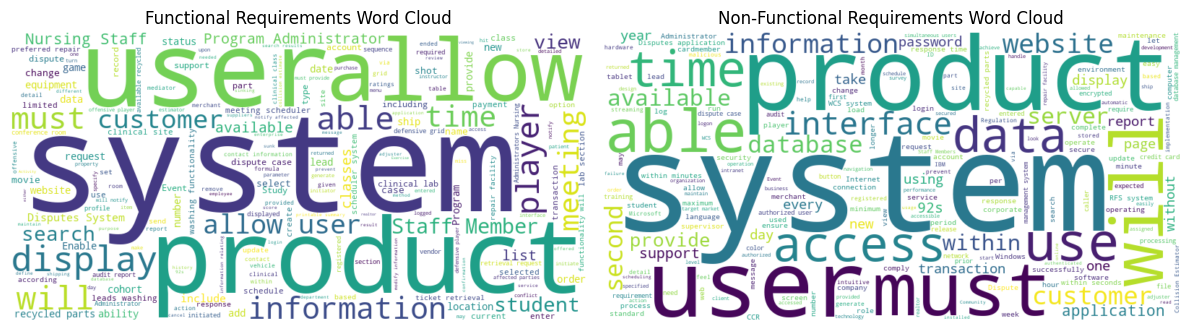

In [22]:
# Separate the data based on class
functional_text = " ".join(df1[df1['_class_'] == 'F']['RequirementText'])
non_functional_text = " ".join(df1[df1['_class_'] == 'NF']['RequirementText'])

# Generate word clouds for both categories
functional_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(functional_text)
non_functional_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(non_functional_text)

# Plotting both word clouds
plt.figure(figsize=(12, 6))

# Plot for Functional
plt.subplot(1, 2, 1)
plt.imshow(functional_wordcloud, interpolation='bilinear')
plt.title("Functional Requirements Word Cloud")
plt.axis('off')

# Plot for Non-Functional
plt.subplot(1, 2, 2)
plt.imshow(non_functional_wordcloud, interpolation='bilinear')
plt.title("Non-Functional Requirements Word Cloud")
plt.axis('off')

plt.tight_layout()
plt.show()

### Creating training, test and validation splits 

In [28]:
train_val_data,test_data = train_test_split(df1,train_size=0.8,random_state=19)
train_data,val_data = train_test_split(train_val_data,train_size=0.8,random_state=19)

print(f"Training date shape : {train_data.shape}")
print(f"Test date shape : {test_data.shape}")
print(f"Validation date shape : {val_data.shape}")

Training date shape : (620, 2)

Test date shape : (194, 2)

Validation date shape : (155, 2)

### Data Processing

In [51]:
def preprocess_text(text):
    """
    Preprocess the input text by performing:
    - Expansion of contractions
    - Lowercasing
    - Removal of punctuation, special characters, and numbers
    - Stopword removal
    - Lemmatization

    Parameters:
    - text (str): The input text to preprocess
    - nlp: A spaCy NLP pipeline for tokenization, lemmatization, and stopword detection

    Returns:
    - str: The cleaned and preprocessed text string
    """
    # Step 1: Expand contractions (e.g., "don't" → "do not")
    text = contractions.fix(text)

    # Step 2: Lowercase the text
    text = text.lower()

    # Step 3: Remove special characters, numbers, and punctuation
    text = re.sub(r"[^a-z\s]", "", text)  # Keep only alphabetic characters and spaces

    # Step 4: Tokenize and process with spaCy
    doc = nlp(text)

    # Step 5: Process tokens - lemmatize, remove stopwords, and filter out empty tokens
    tokens = [
        token.lemma_
        for token in doc
        if not token.is_stop and token.lemma_ not in STOP_WORDS and token.lemma_.strip() != ""
    ]

    # Step 6: Join tokens back into a cleaned text string
    processed_text = " ".join(tokens)
    return processed_text


labels = df1['_class_'].unique().tolist()
def create_label_dicts(labels):
    """
    Creates dictionaries mapping label IDs to labels and vice versa.

    Parameters:
    - labels (list): A list of unique labels.

    Returns:
    - id2label (dict): A dictionary mapping label IDs to labels.
    - label2id (dict): A dictionary mapping labels to label IDs.
    """
    id2label = {id: label for id, label in enumerate(labels)}
    label2id = {label: id for id, label in enumerate(labels)}
    return id2label, label2id


In [50]:
def load_model_and_tokenizer(model_name,num_labels):
    """
    Load the BERT tokenizer and model for sequence classification.

    Parameters:
    - model_name (str): The name of the BERT model to use (e.g., "bert-base-uncased")

    Returns:
    - tokenizer: The BERT tokenizer
    - model: The BERT model for sequence classification
    """
    # Load the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained(model_name)

    # Load the BERT model for sequence classification
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

    return tokenizer, model

In [41]:
# Specify the BERT model to use (e.g., "bert-base-uncased") and loading the model
model_name = "bert-base-uncased"

# Load the BERT tokenizer and model
tokenizer, model = load_model_and_tokenizer(model_name,2)

# Check the model architecture
print(model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): BertIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): GELUActivation()
          )
          (output): BertOutput(
            (dense): Linear(in_features=3072, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (pooler): BertPooler(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (activation): Tanh()
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (classifier): Linear(in_features=768, out_features=2, bias=True)
)

### Creating data loaders for training (Finetuning)

In [ ]:
# TextDataset Class
class TextDataset(Dataset):
    def __init__(self, df, text_column, label_column, tokenizer,transform=None, target_transform=None):
        """
        Args:
            df (pd.DataFrame): Input DataFrame containing text and labels.
            text_column (str): Name of the column containing text data.
            label_column (str): Name of the column containing labels.
            transform (callable, optional): Transformation for text data (e.g., preprocessing).
            target_transform (callable, optional): Transformation for target labels.
        """
        self.data = df
        self.texts = self.data[text_column].tolist()
        self.labels = self.data[label_column].tolist()
        self.transform = transform
        self.target_transform = target_transform

        # Convert textual labels (e.g., 'positive', 'negative') to integers
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.encoded_labels[idx]

        # Apply text preprocessing if specified
        if self.transform:
            text = self.transform(text)

        # Apply target transformation (e.g., one-hot encoding) if specified
        if self.target_transform:
            label = self.target_transform(label)

        return text, torch.tensor(label, dtype=torch.float32)

In [52]:
# Example text
text = "The system shouldn't crash even with 1000 concurrent users!"
clearn = preprocess_text(text)
tokenizer(clearn)

{'input_ids': [101, 2291, 5823, 16483, 5310, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

# Stage 1 : Classification

# Stage 2 : Classification